In [ ]:
%matplotlib inline


# Plot the decision surfaces of ensembles of trees on the iris dataset


Plot the decision surfaces of forests of randomized trees trained on pairs of
features of the iris dataset.

This plot compares the decision surfaces learned by a decision tree classifier
(first column), by a random forest classifier (second column), by an extra-
trees classifier (third column) and by an AdaBoost classifier (fourth column).

In the first row, the classifiers are built using the sepal width and
the sepal length features only, on the second row using the petal length and
sepal length only, and on the third row using the petal width and the
petal length only.

In descending order of quality, when trained (outside of this example) on all
4 features using 30 estimators and scored using 10 fold cross validation,
we see::

    ExtraTreesClassifier()  # 0.95 score
    RandomForestClassifier()  # 0.94 score
    AdaBoost(DecisionTree(max_depth=3))  # 0.94 score
    DecisionTree(max_depth=None)  # 0.94 score

Increasing `max_depth` for AdaBoost lowers the standard deviation of
the scores (but the average score does not improve).

See the console's output for further details about each model.

In this example you might try to:

1) vary the ``max_depth`` for the ``DecisionTreeClassifier`` and
   ``AdaBoostClassifier``, perhaps try ``max_depth=3`` for the
   ``DecisionTreeClassifier`` or ``max_depth=None`` for ``AdaBoostClassifier``
2) vary ``n_estimators``

It is worth noting that RandomForests and ExtraTrees can be fitted in parallel
on many cores as each tree is built independently of the others. AdaBoost's
samples are built sequentially and so do not use multiple cores.


Automatically created module for IPython interactive environment
DecisionTree with features [1, 2] has a score of 0.7770034843205574


ValueError: 'c' argument has 3 elements, which is not acceptable for use with 'x' with size 287, 'y' with size 287.

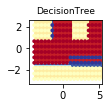

In [31]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from matplotlib.colors import ListedColormap

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 10
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
data = pd.read_csv("data_2020-03-28-engg6500projectNoNANs.csv",
                  index_col=0)

# labelsX = list(data.columns[0:9])
# labelsy = list(data.columns[9:11])
# classnames = ['1', '2', '3']

npData = data.to_numpy()

X_data = npData[:, 0:9]
y_data = npData[:, 9]
y_data=y_data.astype('str')

# X_train, X_test, y_train, y_test =  train_test_split(X_data,y_data,test_size=0.3)

# # normalize the inputs
# X_train_scaled = scale(X_train)
# X_test_scaled = scale(X_test)

# resume given code
plot_idx = 1

models = [DecisionTreeClassifier(max_depth=5),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([1, 2], [2, 3], [1, 3]):
    for model in models:
        # We only take the two corresponding features
        X = X_data[:, pair]
        y = y_data

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
       
        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title, fontsize=9)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedC olormap(['r', 'y', 'b']), edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the driving data", fontsize=12)
plt.axis("tight")

plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.savefig(fname = 'test.png')
plt.show()